In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
import pickle

from tqdm import tqdm
import spacy

In [3]:

if os.path.isfile('extracted_features.csv'):
    df = pd.read_csv('extracted_features.csv', encoding = 'latin-1')
    print("Shape of Extracted Features is: ", df.shape)
else:
    df = extract_features(df)
    df.to_csv('extracted_features.csv', index = False)
    print('After Extraction shape of data is: ', df.shape)
print('Number row which contain NaN: ', df.isnull().values.sum())
df.head(2)

Shape of Extracted Features is:  (404287, 30)
Number row which contain NaN:  0


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_word,q2_n_word,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,...,0.714281,0,1,2,13.0,100,93,93,98,0.965517
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,...,0.307690,0,1,5,10.5,86,63,66,75,0.576923


In [4]:
# split the data
cols = [i for i in df.columns if i not in ['qid1', 'qid2', 'is_duplicate']]
X = df.loc[:,cols]
Y = df.loc[:, 'is_duplicate']
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify = Y, random_state=42)
print('Datapoints in data is: {} and after splitting datapoints in train is: {} and in test is: {}'
      .format(df.shape[0], x_train.shape[0], x_test.shape[0]))

Datapoints in data is: 404287 and after splitting datapoints in train is: 283000 and in test is: 121287


In [5]:
questions = list(x_train['question1']) + list(x_train['question2'])
tfidf = TfidfVectorizer(lowercase=True)
tfidf.fit(questions)
# dict key:word and value:tf-idf score
word_to_idf_score = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
print('Lenght of features of tf-idf vector: ', len(tfidf.get_feature_names()))

Lenght of features of tf-idf vector:  74450


In [10]:
# for TF-IDF W2V featurization:
# importing the 'en_core_web_sm' (of 96 dimensions) to convert tfidf-w2v
try:
    nlp = spacy.load('en_core_web_sm')
except:
    import en_core_web_sm
    nlp = en_core_web_sm.load()

def tfidf_w2v(col):
    vecs1 = []
    for q1 in tqdm(col.values):
        doc1 = nlp(q1)
        # 96 is the number of dimensions of vectors
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch idf score
            try:
                idf = word_to_idf_score[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)
    return vecs1

def vectorize_question(col):
    new_df = pd.DataFrame()
    new_df['q'] = tfidf_w2v(col)
    new_df[[i for i in range(96)]] = pd.DataFrame(new_df['q'].values.tolist(), index = new_df.index)
    new_df.drop(['q'], axis =1,inplace = True)

    return new_df

def get_TFIDF_W2V(x_train, x_test):
    if os.path.isfile("tfidf_w2v_q1_train.csv") and os.path.isfile("tfidf_w2v_q2_train.csv"):
        tfidf_w2v_q1_train = pd.read_csv("tfidf_w2v_q1_train.csv")
        tfidf_w2v_q2_train = pd.read_csv("tfidf_w2v_q2_train.csv")
    else:
        print('\nTraining data is Vectorizing... \n')
        tfidf_w2v_q1_train = vectorize_question(x_train['question1'])
        tfidf_w2v_q2_train = vectorize_question(x_train['question2'])
    #     saving Vectrized features for future use
        tfidf_w2v_q1_train.to_csv("tfidf_w2v_q1_train.csv", index=False)
        tfidf_w2v_q2_train.to_csv("tfidf_w2v_q2_train.csv", index=False)
        
    if os.path.isfile("tfidf_w2v_q1_test.csv") and os.path.isfile("tfidf_w2v_q2_test.csv"):
        tfidf_w2v_q1_test = pd.read_csv("tfidf_w2v_q1_test.csv")
        tfidf_w2v_q2_test = pd.read_csv("tfidf_w2v_q2_test.csv")
    else:
        print('\nTesting data is Vectorizing...\n')
        tfidf_w2v_q1_test = vectorize_question(x_test['question1'])
        tfidf_w2v_q2_test = vectorize_question(x_test['question2'])
    #     saving Vectrized features for future use
        tfidf_w2v_q1_test.to_csv("tfidf_w2v_q1_test.csv", index=False)
        tfidf_w2v_q2_test.to_csv("tfidf_w2v_q2_test.csv", index=False)

    return tfidf_w2v_q1_train, tfidf_w2v_q2_train, tfidf_w2v_q1_test, tfidf_w2v_q2_test

In [11]:
tfidf_w2v_q1_train, tfidf_w2v_q2_train, tfidf_w2v_q1_test, tfidf_w2v_q2_test = get_TFIDF_W2V(x_train, x_test)


Training data is Vectorizing... 



100%|██████████| 283000/283000 [30:52<00:00, 152.74it/s]



Testing data is Vectorizing...



100%|██████████| 121287/121287 [15:45<00:00, 128.25it/s]


In [12]:
print('Shape of tfidf_w2v_q1_train is:', tfidf_w2v_q1_train.shape)
print('Number row which contain NaN: ', tfidf_w2v_q1_train.isnull().values.sum())
tfidf_w2v_q1_train.head(2)

Shape of tfidf_w2v_q1_train is: (283000, 96)
Number row which contain NaN:  0


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,44.540469,-19.070938,-16.639908,-11.779826,-7.111873,-6.861465,-39.630527,-4.580952,20.885471,-11.597808,...,-2.553219,-6.413270,-40.852172,6.111320,14.084957,-50.566739,-13.960432,8.760801,26.373915,-0.457947
1,10.746112,-3.492661,-11.936501,-7.995458,-3.374975,0.094522,-4.636039,1.559292,1.765404,-11.364084,...,23.212645,4.781097,-14.586803,5.231704,18.662782,-17.900821,15.556857,9.171845,8.052044,-7.578979


In [13]:
print('Shape of tfidf_w2v_q1_train is:', tfidf_w2v_q2_train.shape)
print('Number row which contain NaN: ', tfidf_w2v_q2_train.isnull().values.sum())
tfidf_w2v_q2_train.head(2)

Shape of tfidf_w2v_q1_train is: (283000, 96)
Number row which contain NaN:  0


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,42.546670,-21.504452,-18.763457,-7.154081,-15.505515,9.591375,-30.775071,-9.060859,18.980719,-14.332718,...,22.781542,-12.954414,-36.751302,14.281353,41.092334,-28.596902,-6.572219,26.059037,24.125288,-9.398542
1,-2.135025,-2.754587,-1.758482,0.644848,-7.840916,0.311976,-4.741733,-8.026861,2.506500,-11.088128,...,14.647955,1.969989,-6.816496,19.185661,-2.199687,-5.262588,11.504331,3.671482,2.663522,-2.997796


In [14]:
print('Shape of tfidf_w2v_q1_train is:', tfidf_w2v_q1_test.shape)
print('Number row which contain NaN: ', tfidf_w2v_q1_test.isnull().values.sum())
tfidf_w2v_q1_test.head(2)

Shape of tfidf_w2v_q1_train is: (121287, 96)
Number row which contain NaN:  0


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,34.047561,0.880603,-4.549316,29.034207,-24.984065,21.869545,-46.715059,-44.439406,60.631127,-9.733413,...,1.073894,-27.136431,-32.398364,51.356997,4.545384,-58.169193,6.415846,49.938228,7.374491,19.560784
1,5.458579,-6.752508,-9.919015,-5.898328,-19.969213,17.789298,-1.084897,13.553312,12.380002,2.632154,...,4.916306,10.201545,-20.824773,-15.400585,-4.077880,-15.253931,16.655410,19.287830,11.090500,-14.774601


In [15]:
print('Shape of tfidf_w2v_q1_train is:', tfidf_w2v_q2_test.shape)
print('Number row which contain NaN: ', tfidf_w2v_q2_test.isnull().values.sum())
tfidf_w2v_q2_test.head(2)

Shape of tfidf_w2v_q1_train is: (121287, 96)
Number row which contain NaN:  0


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,11.350196,2.434086,-6.351740,-26.301842,0.836710,37.153316,-6.025390,-22.688163,23.816546,22.428168,...,17.748305,8.500176,15.598544,2.225568,-68.596454,-52.552095,17.881853,9.521155,4.407986,16.109891
1,17.677956,0.108538,-4.869079,-17.232921,-9.025966,26.575260,14.225276,22.548670,6.776925,2.097971,...,4.368774,8.589065,-19.674532,-25.425934,-5.938277,-20.295796,28.375213,13.633062,14.683368,-21.478269


In [16]:
#I'll split the x_train into tfidf_train, tfidf_CV
tfidf_y_test = y_test
tfidf_x_test = x_test

tfidf_x_train, tfidf_cv, tfidf_y_train, tfidf_y_cv = train_test_split(x_train, y_train, test_size = 0.2, 
                                                                      stratify = y_train, random_state = 42)
print('Shape of train, CV and test data are {}, {}, and {}'.format(tfidf_x_train.shape, tfidf_cv.shape, tfidf_x_test.shape))

# I'll fit TF-IDF vectorizer with combined question1 and question2 of tfidf_x_train
# then cv and test data will be transformed using above dictionary
questions = list(tfidf_x_train['question1']) + list(tfidf_x_train['question2'])

tfidf = TfidfVectorizer(max_features = 5000, lowercase=True)
tfidf.fit(questions)

#for train data
tfidf_train_q1, tfidf_train_q2 = tfidf.transform(tfidf_x_train['question1']), tfidf.transform(tfidf_x_train['question2'])
tfidf_cv_q1, tfidf_cv_q2 = tfidf.transform(tfidf_cv['question1']), tfidf.transform(tfidf_cv['question2'])
tfidf_test_q1, tfidf_test_q2 = tfidf.transform(tfidf_x_test['question1']), tfidf.transform(tfidf_x_test['question2'])

Shape of train, CV and test data are (226400, 27), (56600, 27), and (121287, 27)


In [17]:
x_train.head(2)

,id,question1,question2,q1len,q2len,q1_n_word,q2_n_word,word_Common,word_total,word_share,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
155514,155515,which are the best books for iit jam mathematics?,what are the best books for iit-jam mathematics?,49,48,9,8,6.0,17.0,0.352941,...,0.666659,1,0,1,8.5,95,95,95,92,0.551020
400577,400580,what are the best photo startups?,what is a good photo?,33,21,6,5,1.0,11.0,0.090909,...,0.166664,0,1,1,5.5,67,54,50,48,0.272727


In [18]:
# #Now let's merge or stack the data using np.hstack(): https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html
cols = [i for i in x_train.columns if i not in ['id', 'qid1', 'qid2','question1', 'question2']]
x_train = x_train.loc[:,cols].values
x_test = x_test.loc[:, cols].values
tfidf_w2v_q1_train, tfidf_w2v_q2_train = tfidf_w2v_q1_train.values, tfidf_w2v_q2_train.values
tfidf_w2v_q1_test, tfidf_w2v_q2_test = tfidf_w2v_q1_test.values, tfidf_w2v_q2_test.values

X_train = np.hstack((x_train, tfidf_w2v_q1_train, tfidf_w2v_q2_train))
X_test = np.hstack((x_test, tfidf_w2v_q1_test, tfidf_w2v_q2_test))

#let's split the X_train into train and CV datasets 

X_train, X_cv , Y_train, Y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2, random_state = 42)
std_data1 = StandardScaler()
std_data1.fit(X_train)

X_train = std_data1.transform(X_train)
X_cv = std_data1.transform(X_cv)
X_test = std_data1.transform(X_test)

print('Shape of train: {}, CV: {}, and test: {}'.format(X_train.shape, X_cv.shape, X_test.shape))    

Shape of train: (226400, 216), CV: (56600, 216), and test: (121287, 216)


In [19]:
from scipy.sparse import hstack
tfidf_x_train = hstack((tfidf_train_q1, tfidf_train_q2, tfidf_x_train.iloc[:,3:])).tocsr()
tfidf_x_cv = hstack((tfidf_cv_q1, tfidf_cv_q2, tfidf_cv.iloc[:,3:])).tocsr()
tfidf_x_test = hstack((tfidf_test_q1, tfidf_test_q2, tfidf_x_test.iloc[:,3:])).tocsr()

std_data2 = StandardScaler(with_mean=False)
std_data2.fit(tfidf_x_train)

tfidf_x_train = std_data2.transform(tfidf_x_train)
tfidf_x_cv = std_data2.transform(tfidf_x_cv)
tfidf_x_test = std_data2.transform(tfidf_x_test)

print('Shape of train: {}, CV: {}, and test: {}'.format(tfidf_x_train.shape, tfidf_x_cv.shape, tfidf_x_test.shape)) 

Shape of train: (226400, 10024), CV: (56600, 10024), and test: (121287, 10024)


In [20]:
# change the path for model saving

import pickle
with open("std_w2v.pkl", "wb") as f:
    pickle.dump(std_data1, f)

with open("std_tfidf.pkl", "wb") as f:
    pickle.dump(std_data2, f)
    
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("idf_score.pkl", "wb") as f:
    pickle.dump(word_to_idf_score, f)

import gc
gc.collect()

1040

In [21]:
def plot_confusion_matrices(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred) #for confusion matrix
    # for presion matrix: take the sum column wise, i.e. column normalization
    P = C/C.sum(axis = 0)
    #for recall matrix: take the sum row wise, i.e. row normalization
    R = (C.T/C.sum(axis = 1)).T

    fig = plt.figure(figsize=(18,4))
    
    for i, j in enumerate(zip([C,P,R], ['Confusion', 'Precison', 'Recall'])):
        ax = fig.add_subplot(1,3,i+1)
        if i == 0:
            fmts = 'd'
        else:
            fmts = '0.3f'
        #https://seaborn.pydata.org/generated/seaborn.heatmap.html
        sns.heatmap(j[0], annot = True, fmt = fmts, annot_kws={"size":15})
        plt.xlabel('Predicted Class', fontsize = 12)
        plt.ylabel('Original Class', fontsize = 12)
        plt.title(str(j[1])+' '+'Matrix', fontsize = 15) 
    plt.show()

In [22]:
y_true_cv, y_true_test = Y_cv, y_test
# adding two columns: one for probability of class '0' and for probability of class '1'
# i.e. P(y_train_random_pred[0] == 0), P(y_train_random_pred[1] == 1)
y_cv_random_pred = np.zeros((len(y_true_cv), 2)) 
y_test_random_pred = np.zeros((len(y_true_test), 2)) 

for i in range(len(y_true_cv)):
    random_value = np.random.rand(1,2)
    y_cv_random_pred[i] = (random_value/np.sum(random_value))[0]

for i in range(len(y_true_test)):
    random_value = np.random.rand(1,2)
    y_test_random_pred[i] = (random_value/np.sum(random_value))[0]

Log loss for CV Data using Random Model 0.8864


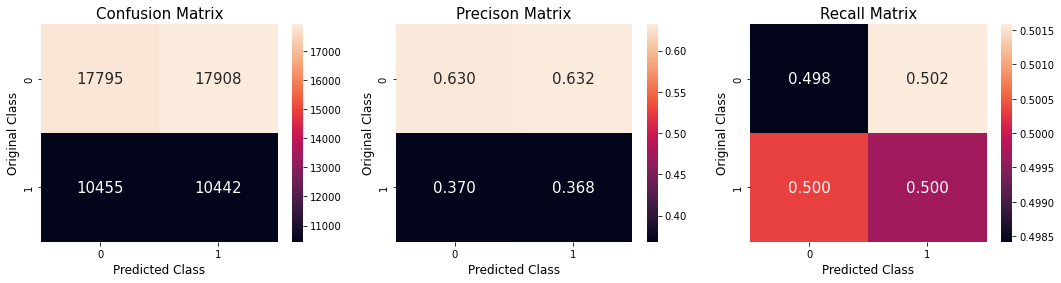

In [23]:
print("Log loss for CV Data using Random Model",round(log_loss(y_true_cv, y_cv_random_pred, eps=1e-15),4))
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html
y_cv_random_pred = np.argmax(y_cv_random_pred, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(y_true_cv, y_cv_random_pred)

Log loss on train Data using Random Model 0.8861


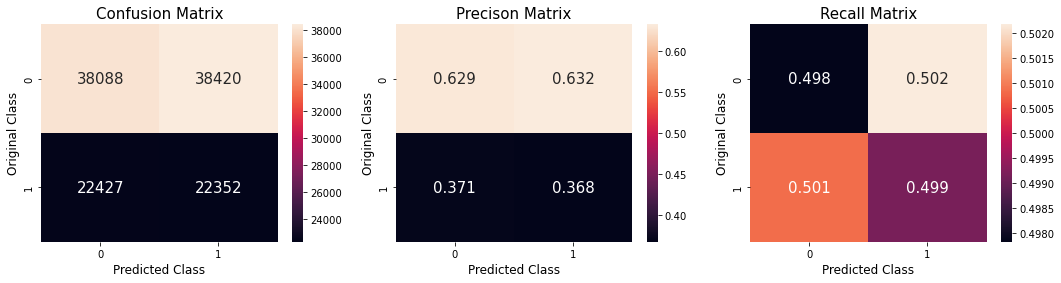

In [24]:
print("Log loss on train Data using Random Model",round(log_loss(y_true_test, y_test_random_pred, eps=1e-15), 4))
y_test_random_pred = np.argmax(y_test_random_pred, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(y_true_test, y_test_random_pred)

In [25]:
a = Y_train.value_counts()
cl_weight = {0: round(a[1]/(a[0]+a[1]),2), 1: round(a[0]/(a[0]+a[1]), 2)}
cl_weight

{0: 0.37, 1: 0.63}

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import calibration_curve

In [28]:
def plot_log_loss(param, train_auc, cv_auc, hyp_name):
    plt.figure(figsize = (10,6))
    plt.plot(param, train_auc, 'bo:', label = 'Train')
    plt.plot(param, cv_auc, 'ro:', label = 'CV')
    plt.title("log-loss vs hyperparameter '{}' for train and CV".format(hyp_name), fontsize = 15)
    plt.xlabel('hyperparameter '+str(hyp_name), fontsize = 12)
    plt.ylabel('log-loss', fontsize = 12)
    plt.legend()
    plt.grid(1)
    plt.show()

In [29]:
log_loss_train = []
log_loss_cv=[]
c = np.array([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4])
for j,i in enumerate(c):
    clf = LogisticRegression(penalty = 'l2', class_weight= cl_weight, C = i, random_state = 42)
    clf.fit(tfidf_x_train, tfidf_y_train.values)
    
    calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf.fit(tfidf_x_train, tfidf_y_train.values)
    
    Y_pred_train = calib_clf.predict_proba(tfidf_x_train)
    Y_pred_CV = calib_clf.predict_proba(tfidf_x_cv) 
    
    log_loss_train.append(log_loss(tfidf_y_train, Y_pred_train, labels= calib_clf.classes_, eps=1e-15))
    log_loss_cv.append(log_loss(tfidf_y_cv, Y_pred_CV, labels= calib_clf.classes_, eps=1e-15)) 
    
    print('for C = {} log-loss for train is {} and for CV is {}'.format(i,log_loss_train[j], log_loss_cv[j]))

for C = 0.0001 log-loss for train is 0.3976399730644411 and for CV is 0.41976524657753583
for C = 0.001 log-loss for train is 0.37875221949417676 and for CV is 0.41122954670638434
for C = 0.01 log-loss for train is 0.37539807643174866 and for CV is 0.41180444788602827
for C = 0.1 log-loss for train is 0.3761558342891091 and for CV is 0.41344337750398696
for C = 1.0 log-loss for train is 0.37626670902414955 and for CV is 0.4135458908317351
for C = 10.0 log-loss for train is 0.37632428117822675 and for CV is 0.4137207797003827
for C = 100.0 log-loss for train is 0.37638774271593434 and for CV is 0.413785739321196
for C = 1000.0 log-loss for train is 0.37636230470175436 and for CV is 0.4138118722199507
for C = 10000.0 log-loss for train is 0.3763136273724189 and for CV is 0.4137281752464885


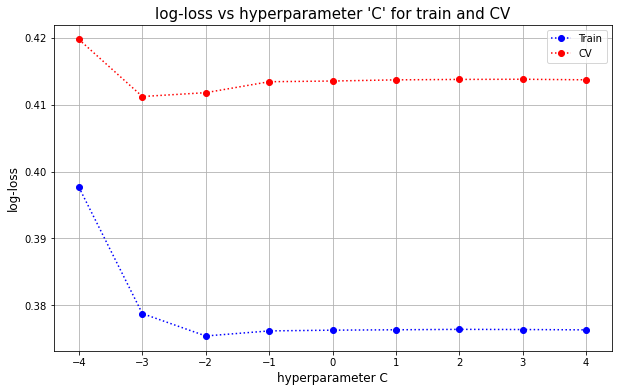

In [30]:
plot_log_loss(np.log10(c), log_loss_train, log_loss_cv, hyp_name = 'C')

In [31]:
LR = LogisticRegression(penalty = 'l2', class_weight= cl_weight, random_state = 42, C = 0.001) #L2 norm
LR.fit(tfidf_x_train, tfidf_y_train.values)
calib_LR = CalibratedClassifierCV(LR, method="sigmoid")
calib_LR.fit(tfidf_x_train, tfidf_y_train.values)
y_prob_train = calib_LR.predict_proba(tfidf_x_train)
y_prob_test = calib_LR.predict_proba(tfidf_x_test)

Log loss on train Data 0.3788


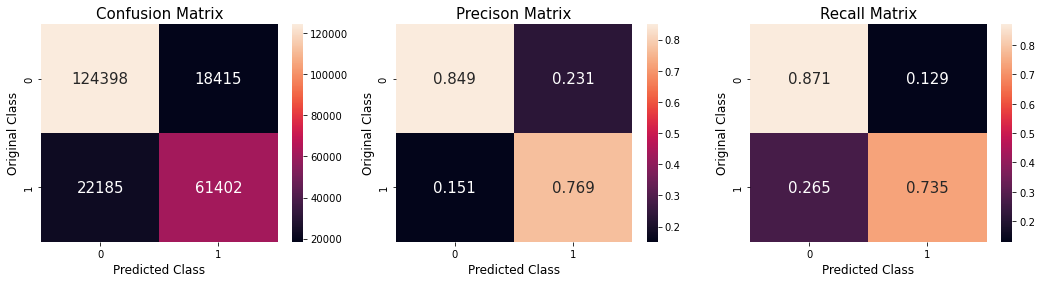

Log loss on test Data 0.4115


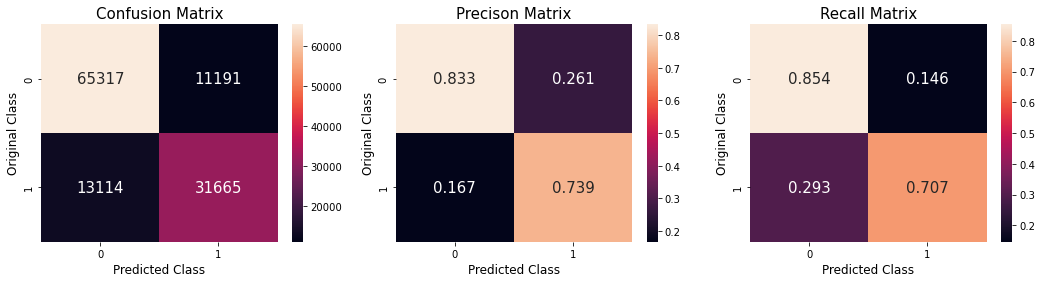

In [32]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(tfidf_y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(tfidf_y_test, y_test_pred)

In [33]:
log_loss_train = []
log_loss_cv=[]
c = np.array([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4])
for j,i in enumerate(c):
    clf = LogisticRegression(penalty = 'l2', class_weight= cl_weight, C = i, random_state = 42)
    clf.fit(X_train, Y_train.values)
    
    calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf.fit(X_train, Y_train.values)
    
    Y_pred_train = calib_clf.predict_proba(X_train)
    Y_pred_CV = calib_clf.predict_proba(X_cv) 
    
    log_loss_train.append(log_loss(Y_train, Y_pred_train, labels= calib_clf.classes_, eps=1e-15))
    log_loss_cv.append(log_loss(Y_cv, Y_pred_CV, labels= calib_clf.classes_, eps=1e-15)) 
    
    print('for C = {} log-loss for train is {} and for CV is {}'.format(i,log_loss_train[j], log_loss_cv[j]))

for C = 0.0001 log-loss for train is 0.5053652071325889 and for CV is 0.5044451419240498
for C = 0.001 log-loss for train is 0.4846916469866932 and for CV is 0.4838473031887216
for C = 0.01 log-loss for train is 0.47981414086194474 and for CV is 0.47895952998087665
for C = 0.1 log-loss for train is 0.47912751888213245 and for CV is 0.47830710948389993
for C = 1.0 log-loss for train is 0.47909330749916706 and for CV is 0.47829293252031263
for C = 10.0 log-loss for train is 0.47909715663441343 and for CV is 0.4782924780901979
for C = 100.0 log-loss for train is 0.479091217275651 and for CV is 0.4782887274951985
for C = 1000.0 log-loss for train is 0.4790903400387983 and for CV is 0.47828930290094346
for C = 10000.0 log-loss for train is 0.4790900771204343 and for CV is 0.4782932947936917


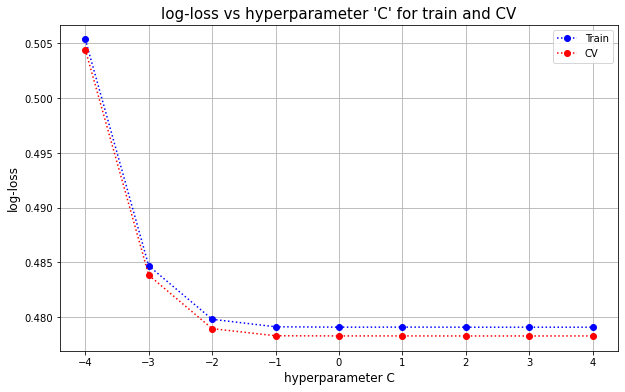

In [34]:
plot_log_loss(np.log10(c), log_loss_train, log_loss_cv, hyp_name = 'C')


In [35]:
LR = LogisticRegression(penalty = 'l2', class_weight= cl_weight, random_state = 42, C = 10**0) #L2 norm
LR.fit(X_train, Y_train)
calib_LR = CalibratedClassifierCV(LR, method="sigmoid")
calib_LR.fit(X_train, Y_train)
y_prob_train = calib_LR.predict_proba(X_train)
y_prob_test = calib_LR.predict_proba(X_test)

Log loss on train Data 0.4791


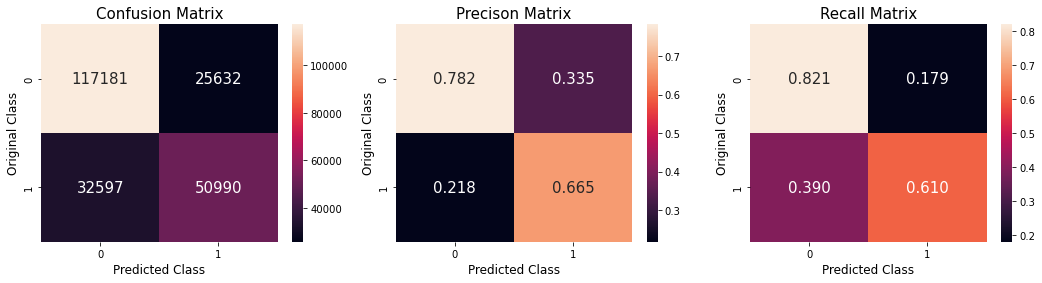

Log loss on test Data 0.4805


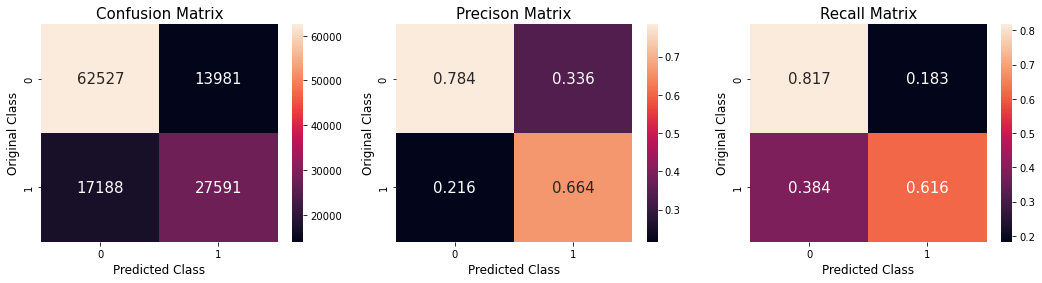

In [36]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(Y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(y_test, y_test_pred)

In [37]:
log_loss_train = []
log_loss_cv=[]
c = np.array([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4])
for j,i in enumerate(c):
    clf = SGDClassifier(alpha = i, penalty='l1', loss='hinge', 
                        class_weight= cl_weight, n_jobs=-1, random_state=42)
    clf.fit(tfidf_x_train, tfidf_y_train.values)
    
    calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf.fit(tfidf_x_train, tfidf_y_train.values)
    
    Y_pred_train = calib_clf.predict_proba(tfidf_x_train)
    Y_pred_CV = calib_clf.predict_proba(tfidf_x_cv) 
    
    log_loss_train.append(log_loss(tfidf_y_train, Y_pred_train, labels= calib_clf.classes_, eps=1e-15))
    log_loss_cv.append(log_loss(tfidf_y_cv, Y_pred_CV, labels= calib_clf.classes_, eps=1e-15)) 
    
    print('for C = {} log-loss for train is {} and for CV is {}'.format(i,log_loss_train[j], log_loss_cv[j]))

for C = 0.0001 log-loss for train is 0.5875447476748547 and for CV is 0.5939517171062243
for C = 0.001 log-loss for train is 0.6499133140290028 and for CV is 0.6504392897259798
for C = 0.01 log-loss for train is 0.6577537170656049 and for CV is 0.6578517376948486
for C = 0.1 log-loss for train is 0.6581928354165841 and for CV is 0.6581872455945579
for C = 1.0 log-loss for train is 0.658356181384103 and for CV is 0.6583266624295644
for C = 10.0 log-loss for train is 0.6585131544951093 and for CV is 0.6585002071753991
for C = 100.0 log-loss for train is 0.6585288179345656 and for CV is 0.6585311838712791
for C = 1000.0 log-loss for train is 0.6585288179345656 and for CV is 0.6585311838712791
for C = 10000.0 log-loss for train is 0.6585288179345656 and for CV is 0.6585311838712791


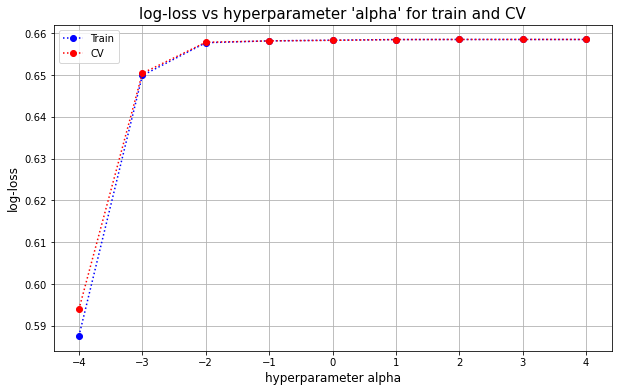

In [38]:
plot_log_loss(np.log10(c), log_loss_train, log_loss_cv, hyp_name = 'alpha')

In [39]:
SVM = SGDClassifier(alpha = 10**-4, penalty='l1', loss='hinge', 
                    class_weight= cl_weight, n_jobs=-1, random_state=42) 
SVM.fit(X_train, Y_train.values)
calib_LR = CalibratedClassifierCV(SVM, method="sigmoid")
calib_LR.fit(X_train, Y_train.values)
y_prob_train = calib_LR.predict_proba(X_train)
y_prob_test = calib_LR.predict_proba(X_test)

Log loss on train Data 0.4818


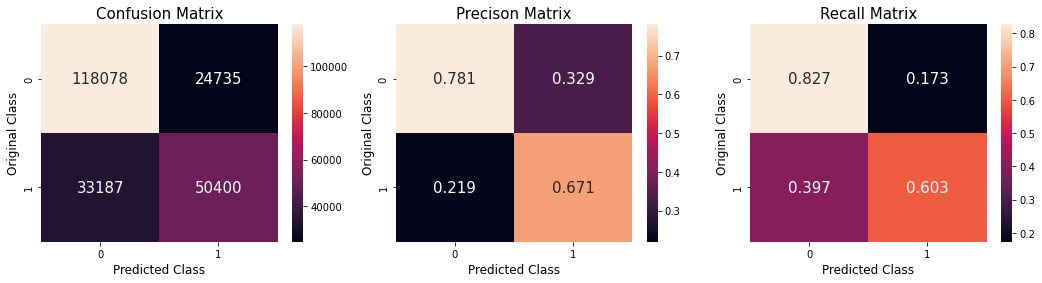

Log loss on test Data 0.4837


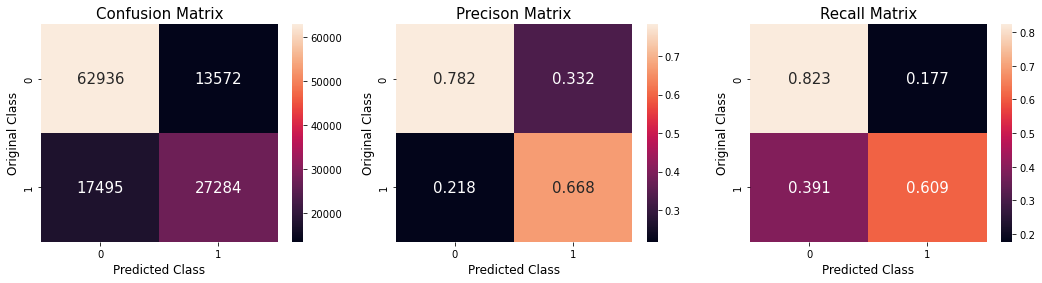

In [40]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(Y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(y_test, y_test_pred)

In [42]:
estimators = np.array([10, 50, 100, 200, 400, 500]) #estimators
depths = np.array( [2, 4, 6, 8, 10])#

try:
    train_log_loss1 = pd.read_csv('xgb_light_train.csv')
    #to make dtype of index and column as intiger, otherwise they'll be string: https://stackoverflow.com/a/45452124
    train_log_loss1.index, train_log_loss1.columns  = estimators, depths 
    cv_log_loss1 = pd.read_csv('xgb_light_cv.csv')
    cv_log_loss1.index, cv_log_loss1.columns = estimators, depths
except:
    train_log_loss1 = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    cv_log_loss1    = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    
print('{} pairs are left to be check to tune the hyperparamter:'.format((cv_log_loss1 == 0).values.sum()))

for est in estimators:
    for depth in depths:
        if train_log_loss1.loc[est,depth] == 0 and cv_log_loss1.loc[est,depth] == 0: 
            print('Training and calibrating for: n_estimators = {}, max_depth = {}'.format(est, depth))
           
            # scikit-learn API: https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMClassifier
            XGB = LGBMClassifier(boosting_type = 'gbdt', max_depth = depth, n_estimators= est, class_weight = cl_weight)
            XGB.fit(tfidf_x_train, tfidf_y_train.values)

            calib_clf = CalibratedClassifierCV(XGB, method="sigmoid")
            calib_clf.fit(tfidf_x_train, tfidf_y_train.values)

            Y_pred_train = calib_clf.predict_proba(tfidf_x_train)
            Y_pred_CV = calib_clf.predict_proba(tfidf_x_cv)
            
            # finding the log-loss value
            train_log_loss1.loc[est,depth] = np.round(log_loss(tfidf_y_train, Y_pred_train, labels = XGB.classes_, eps=1e-15),4)
            cv_log_loss1.loc[est,depth] = np.round(log_loss(tfidf_y_cv, Y_pred_CV, labels= XGB.classes_, eps=1e-15),4)
            
            # save the value in each iteration
            train_log_loss1.to_csv('xgb_light_train.csv', index=False)
            cv_log_loss1.to_csv('xgb_light_cv.csv', index=False)

30 pairs are left to be check to tune the hyperparamter:
Training and calibrating for: n_estimators = 10, max_depth = 2
Training and calibrating for: n_estimators = 10, max_depth = 4
Training and calibrating for: n_estimators = 10, max_depth = 6
Training and calibrating for: n_estimators = 10, max_depth = 8
Training and calibrating for: n_estimators = 10, max_depth = 10
Training and calibrating for: n_estimators = 50, max_depth = 2
Training and calibrating for: n_estimators = 50, max_depth = 4
Training and calibrating for: n_estimators = 50, max_depth = 6
Training and calibrating for: n_estimators = 50, max_depth = 8
Training and calibrating for: n_estimators = 50, max_depth = 10
Training and calibrating for: n_estimators = 100, max_depth = 2
Training and calibrating for: n_estimators = 100, max_depth = 4
Training and calibrating for: n_estimators = 100, max_depth = 6
Training and calibrating for: n_estimators = 100, max_depth = 8
Training and calibrating for: n_estimators = 100, max_d

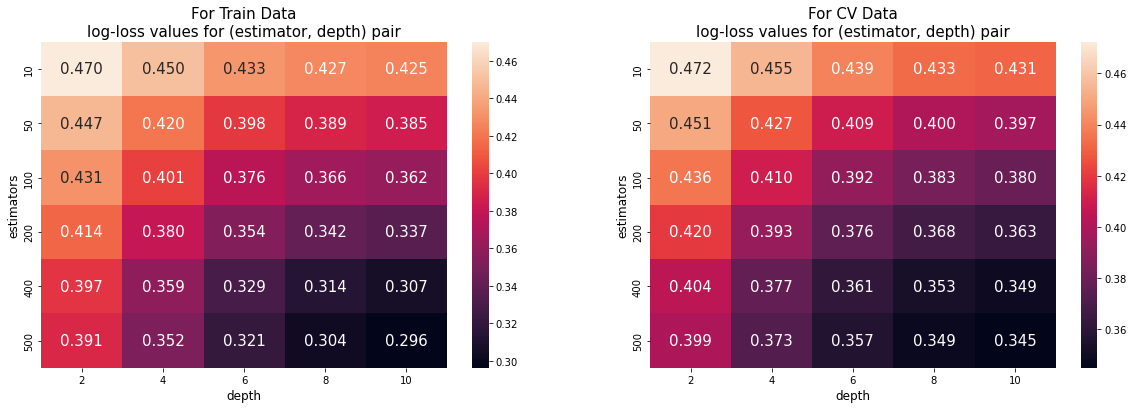

In [43]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.heatmap(train_log_loss1, annot = True, fmt = '0.3f', annot_kws={"size":15})
plt.ylabel('estimators', fontsize = 12)
plt.xlabel('depth', fontsize = 12)
plt.title('For Train Data\nlog-loss values for (estimator, depth) pair', fontsize = 15)  

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.heatmap(cv_log_loss1, annot = True, fmt = '0.3f', annot_kws={"size":15})
plt.ylabel('estimators', fontsize = 12)
plt.xlabel('depth', fontsize = 12)
plt.title('For CV Data\nlog-loss values for (estimator, depth) pair', fontsize = 15)
plt.show()

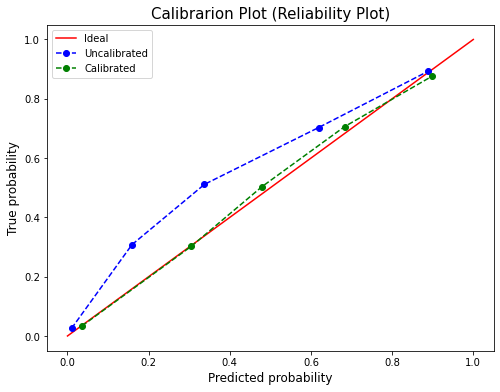

In [44]:
if os.path.isfile('tfidf_GBDT_model.pkl'):
    with open('tfidf_GBDT_model.pkl', 'rb') as f:
        calib_gbdt_tfidf = pickle.load(f)
else:
    XGB = LGBMClassifier(boosting_type = 'gbdt', max_depth = 10, n_estimators= 500, 
                         class_weight = cl_weight, random_state=42) 
    XGB.fit(tfidf_x_train, tfidf_y_train.values)
    calib_gbdt_tfidf = CalibratedClassifierCV(XGB, method="sigmoid")
    calib_gbdt_tfidf.fit(tfidf_x_train, tfidf_y_train.values)
    
    #save the model
    with open('tfidf_GBDT_model.pkl', 'wb') as f:
        pickle.dump(calib_gbdt_tfidf, f)

#let's whether it needs calibration or not
true_uncalib, pred_uncalib = calibration_curve(tfidf_y_test, XGB.predict_proba(tfidf_x_test)[:,1])
true_calib, pred_calib = calibration_curve(tfidf_y_test, calib_gbdt_tfidf.predict_proba(tfidf_x_test)[:,1])

#let's plot them:
plt.figure(figsize = (8,6))
plt.plot([0,1], [0,1], 'r-', label = 'Ideal')
plt.plot(true_uncalib, pred_uncalib, 'bo--', label = 'Uncalibrated')
plt.plot(true_calib, pred_calib, 'go--', label = 'Calibrated')
plt.title('Calibrarion Plot (Reliability Plot)', fontsize = 15)
plt.xlabel('Predicted probability', fontsize = 12)
plt.ylabel('True probability', fontsize = 12)
plt.legend()
plt.show()


Log loss on train Data 0.2963


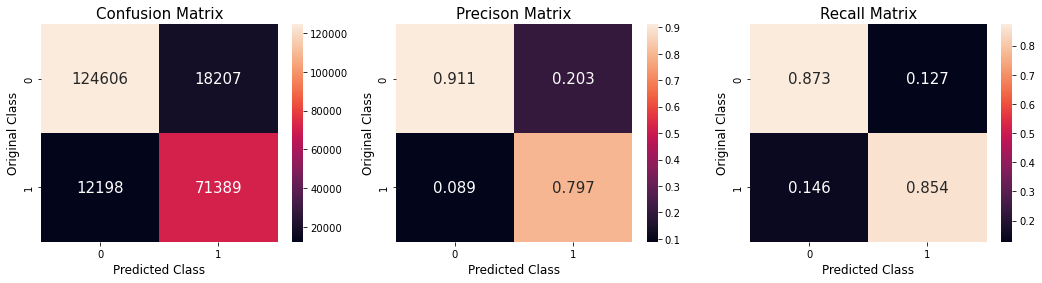

Log loss on test Data 0.3422


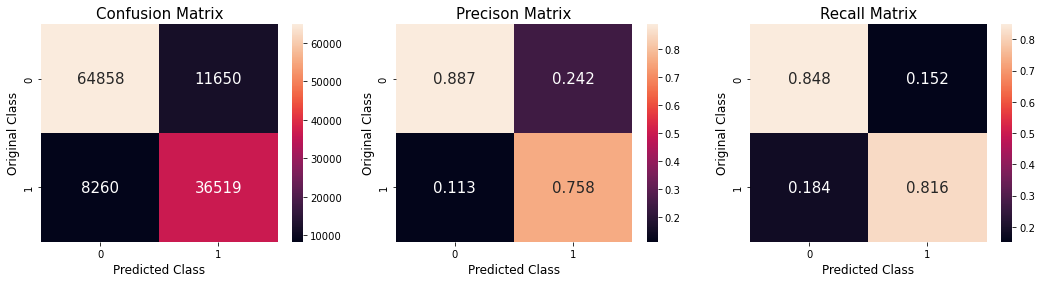

In [45]:
y_prob_train = calib_gbdt_tfidf.predict_proba(tfidf_x_train)
y_prob_test = calib_gbdt_tfidf.predict_proba(tfidf_x_test)
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(tfidf_y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(tfidf_y_test, y_test_pred)

In [46]:
estimators = np.array([10, 50, 100, 200, 400, 500]) #estimators
depths = np.array( [2, 4, 6, 8, 10])#

try:
    train_log_loss = pd.read_csv('xgb_light_train5.csv')
    #to make dtype of index and column as intiger, otherwise they'll be string: https://stackoverflow.com/a/45452124
    train_log_loss.index, train_log_loss.columns  = estimators, depths 
    cv_log_loss = pd.read_csv('xgb_light_cv5.csv')
    cv_log_loss.index, cv_log_loss.columns = estimators, depths
except:
    train_log_loss = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    cv_log_loss    = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    
print('{} pairs are left to be check to tune the hyperparamter:'.format((cv_log_loss == 0).values.sum()))

for est in estimators:
    for depth in depths:
        if train_log_loss.loc[est,depth] == 0 and cv_log_loss.loc[est,depth] == 0: 
            print('Training and calibrating for: n_estimators = {}, max_depth = {}'.format(est, depth))
           
            # scikit-learn API: https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMClassifier
            XGB = LGBMClassifier(boosting_type = 'gbdt', max_depth = depth, n_estimators= est, class_weight = cl_weight)
            XGB.fit(X_train, Y_train.values)

            calib_clf = CalibratedClassifierCV(XGB, method="sigmoid")
            calib_clf.fit(X_train, Y_train.values)

            Y_pred_train = calib_clf.predict_proba(X_train)
            Y_pred_CV = calib_clf.predict_proba(X_cv)
            
            # finding the log-loss value
            train_log_loss.loc[est,depth] = np.round(log_loss(Y_train, Y_pred_train, labels = XGB.classes_, eps=1e-15),4)
            cv_log_loss.loc[est,depth] = np.round(log_loss(Y_cv, Y_pred_CV, labels= XGB.classes_, eps=1e-15),4)
            
            # save the value in each iteration
            train_log_loss.to_csv('xgb_light_train5.csv', index=False)
            cv_log_loss.to_csv('xgb_light_cv5.csv', index=False)
            

30 pairs are left to be check to tune the hyperparamter:
Training and calibrating for: n_estimators = 10, max_depth = 2
Training and calibrating for: n_estimators = 10, max_depth = 4
Training and calibrating for: n_estimators = 10, max_depth = 6
Training and calibrating for: n_estimators = 10, max_depth = 8
Training and calibrating for: n_estimators = 10, max_depth = 10
Training and calibrating for: n_estimators = 50, max_depth = 2
Training and calibrating for: n_estimators = 50, max_depth = 4
Training and calibrating for: n_estimators = 50, max_depth = 6
Training and calibrating for: n_estimators = 50, max_depth = 8
Training and calibrating for: n_estimators = 50, max_depth = 10
Training and calibrating for: n_estimators = 100, max_depth = 2
Training and calibrating for: n_estimators = 100, max_depth = 4
Training and calibrating for: n_estimators = 100, max_depth = 6
Training and calibrating for: n_estimators = 100, max_depth = 8
Training and calibrating for: n_estimators = 100, max_d

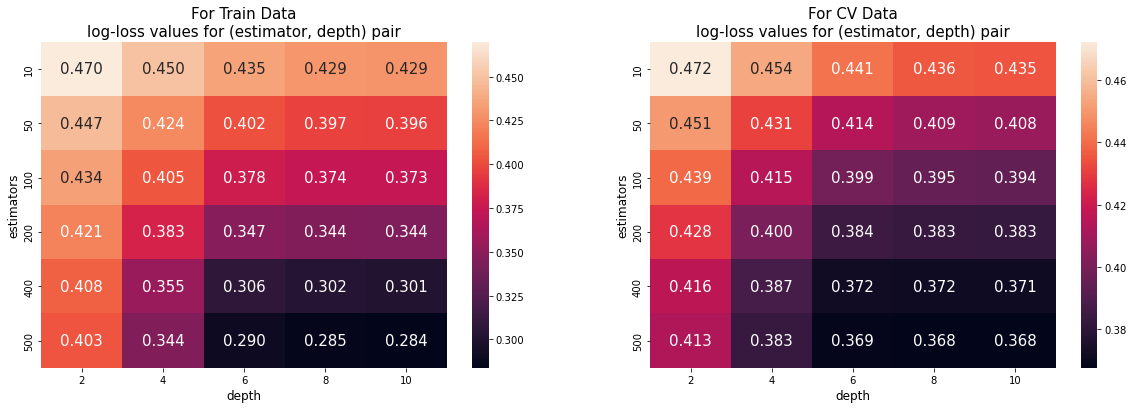

In [47]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.heatmap(train_log_loss, annot = True, fmt = '0.3f', annot_kws={"size":15})
plt.ylabel('estimators', fontsize = 12)
plt.xlabel('depth', fontsize = 12)
plt.title('For Train Data\nlog-loss values for (estimator, depth) pair', fontsize = 15)  

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.heatmap(cv_log_loss, annot = True, fmt = '0.3f', annot_kws={"size":15})
plt.ylabel('estimators', fontsize = 12)
plt.xlabel('depth', fontsize = 12)
plt.title('For CV Data\nlog-loss values for (estimator, depth) pair', fontsize = 15)
plt.show()

In [48]:
if os.path.isfile('tfidf_w2v_GBDT_model.pkl'):
    with open('tfidf_w2v_GBDT_model.pkl', 'rb') as f:
        calib_gbdt_tfidf_w2v = pickle.load(f)
else:
    XGB = LGBMClassifier(boosting_type = 'gbdt', max_depth = 6, n_estimators= 500, 
                         class_weight = cl_weight, random_state=42) 
    XGB.fit(X_train, Y_train.values)
    calib_gbdt_tfidf_w2v = CalibratedClassifierCV(XGB, method="sigmoid")
    calib_gbdt_tfidf_w2v.fit(X_train, Y_train.values)
    
    #save the model
    with open('tfidf_w2v_GBDT_model.pkl', 'wb') as f:
        pickle.dump(calib_gbdt_tfidf_w2v, f)
        
y_prob_train = calib_gbdt_tfidf_w2v.predict_proba(X_train)
y_prob_test = calib_gbdt_tfidf_w2v.predict_proba(X_test)

Log loss on train Data 0.2903


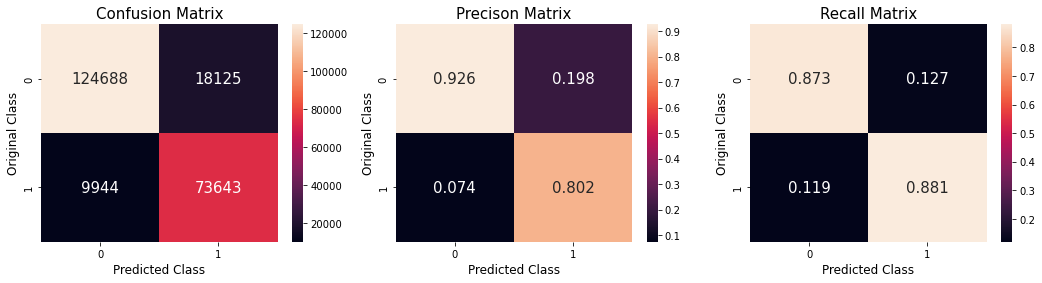

Log loss on test Data 0.3687


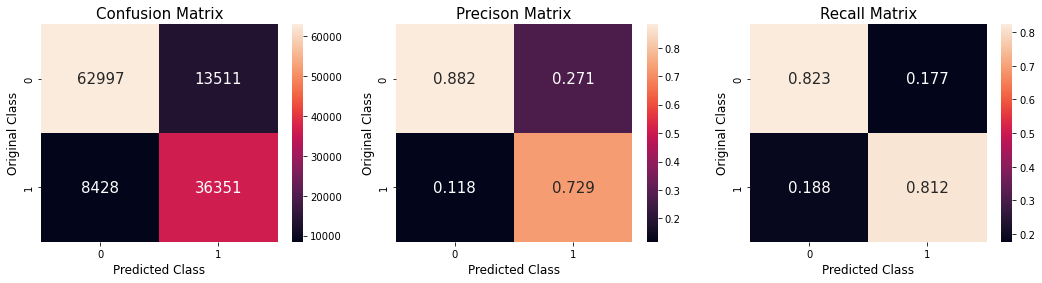

In [49]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(Y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) # row wise getting the index whichever is bigger, returns 0 or 1
plot_confusion_matrices(y_test, y_test_pred)

In [51]:
from prettytable import PrettyTable
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
x.field_names = ["Model", "hyperparameter", "Train Log-Loss", "Test Log-Loss"]
x.add_row(['Random Model', 'None', 0.8778 , 0.884])
x.add_row(['Logistic Regression (TFIDF)', 'C = 0.001', 0.3788, 0.4114])
x.add_row(['Logistic Regression (TFIDF-W2V)', 'C = 1', 0.4808, 0.4812])
x.add_row(['Linear SVM (TFIDF)', 'alpha = 10**-4',0.5845, 0.591])
x.add_row(['Linear SVM (TFIDF-W2V)', 'alpha = 10**-4', 0.4831, 0.4838])
x.add_row(['GBDT (TFIDF)', 'depth = 10, estimators = 500', 0.2965, 0.3423])
x.add_row(['GBDT (TFIDF-W2V)', 'depth = 8, estimators = 500', 0.2959, 0.3732])
print(x)

+---------------------------------+------------------------------+----------------+---------------+
|              Model              |        hyperparameter        | Train Log-Loss | Test Log-Loss |
+---------------------------------+------------------------------+----------------+---------------+
|           Random Model          |             None             |     0.8778     |     0.884     |
|   Logistic Regression (TFIDF)   |          C = 0.001           |     0.3788     |     0.4114    |
| Logistic Regression (TFIDF-W2V) |            C = 1             |     0.4808     |     0.4812    |
|        Linear SVM (TFIDF)       |        alpha = 10**-4        |     0.5845     |     0.591     |
|      Linear SVM (TFIDF-W2V)     |        alpha = 10**-4        |     0.4831     |     0.4838    |
|           GBDT (TFIDF)          | depth = 10, estimators = 500 |     0.2965     |     0.3423    |
|         GBDT (TFIDF-W2V)        | depth = 8, estimators = 500  |     0.2959     |     0.3732    |
